In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from scipy.optimize import shgo
from mpl_toolkits.mplot3d import Axes3D
import time
import datetime

import topo_generic as topo
import JHD
import importlib
importlib.reload(topo)
importlib.reload(JHD)

#%matplotlib widget  ## better to use this for interactive plot with jupyter lab
%matplotlib inline 

# Fig5 computation

**Algorithm summary**

The goal of this algorithm is to find the minimum excitation in the $\phi_L,\phi_R$ plane, for different values of $\phi_B$ and $n_g$.

To do so, I first fix $\phi_B$. Then I look for the minimum excitation energy in the whole $\phi_L,\phi_R$ plane, and in a small $n_g$ interval.

Due to the symmetry of the circuit, I only compute the energy gap for $n_g$ in [0,0.5], and for $\phi_B$ in [0,$pi$]. Then I just mirror the data for the whole parameter space.

**Runtime**

This computation requires quite some time for a high resolution as in figure 5 of https://arxiv.org/pdf/2009.03291.pdf 

On a regular desktop computer, it may take more than a day.

It helps to parallelize the computation.

The datas used in https://arxiv.org/pdf/2009.03291.pdf are loaded in part 2.



In [ ]:
%%time

Ej=1
Ec=1

N=13

asym=[1,0.8,1.1,0.9,1.2]

tol=1e-8

phiBlist=np.linspace(0,np.pi,101)
dimphiB=len(phiBlist)

nglist=np.linspace(0,0.5,101)
dimng=len(nglist)
    
deg_gap=np.zeros([dimphiB,dimng])
deg_pos=np.zeros([dimphiB,dimng,4]) #4 coordinates: L, R, ng, phiB
deg_time=np.zeros([dimphiB,dimng])

for (iphiB,phiB) in enumerate(phiBlist):
    print('phiB : ',phiB)
    print('{datetime}'.format(datetime=datetime.datetime.now()))
    param=[N,Ej,Ec,phiB,asym,tol]
    start_time=time.time()
    
    for (ing,ng) in enumerate(nglist):
        start_time_ng=time.time()
        print(ing)
        if ing%10==0:
            print(f'ing is {ing}')
        if ing==0: continue ##skip first iteration to use end of interval to define it
            
        bnds=((0,2*np.pi), (0,2*np.pi), (nglist[ing-1],nglist[ing]))
        
        temp_deg=shgo(JHD.minimize_phiL_phiR_ng,bnds,args=param, \
                      n=151, iters=15, sampling_method='sobol', \
                      minimizer_kwargs={'method':'SLSQP', 'options':{'options':{'ftol':1e-8, 'eps':1e-10, 'maxiter':100}}}, \
                      options={'ftol':1e-8, 'maxtime':60, 'local_iter':10} )


        deg_time[iphiB,ing]=time.time()-start_time
        deg_gap[iphiB,ing]=temp_deg.fun
        deg_pos[iphiB,ing]=np.hstack([temp_deg.x,phiB])
        
        print(f'gap: {deg_gap[iphiB,ing]} \t ng: {deg_pos[iphiB,ing,2]} \t phiB: {deg_pos[iphiB,ing,3]}')
        if ing%10==0:
            print(f'this ng run took {time.time()-start_time_ng:.4f}sec')
        print()
    print(f'{time.time()-start_time}sec for this phiB run')
    print(f'estimate remaining time to {(time.time()-start_time)*(dimphiB-iphiB+1)/60}min')

# load data and display fig5

**Load data**

==> skip if data were computed in previous part

In [2]:
phiBlist=np.linspace(0,np.pi,101)
nglist=np.linspace(0,0.5,101)

with open('fig5_data/JHD_fig5.pkl', 'rb') as outfile:
    deg_gap,deg_pos=pickle.load(outfile)

**mirror symmetry to enlarge to full parameter space**

In [6]:
def unfold(phiBlist,nglist,deg_gap):
    ##### first let's double phiB resolution, and remove first ng point (which is zero) ####
    print('initial degen shape is ',np.shape(deg_gap))
    #double phiB size
    phiBlist=np.linspace(phiBlist[0],phiBlist[-1],2*len(phiBlist)-1)
    #shift half interval so that phiB[i] is center of interval i
    phiBlist=phiBlist[:-1]+0.5*(phiBlist[1]-phiBlist[0])
    
    #double phiB resolution for deg_gap (minus two points at extremities) and remove one ng point (first one is zero)
    deg_gap_double=np.empty([2*len(deg_gap)-2,len(deg_gap)-1])
    #extremities counted once
    deg_gap_double[0]=deg_gap[0,1:]
    deg_gap_double[-1]=deg_gap[-1,1:]
    #other phiB points doubled with same value
    for i in range(1,len(deg_gap)-1):
        deg_gap_double[2*i-1]=deg_gap[i,1:]
        deg_gap_double[2*i]=deg_gap[i,1:]
    print('shape after doubling phiB resolution is ',np.shape(deg_gap_double))
    deg_gap=deg_gap_double
    
    #### now unfold in both direction to cover whole parameter space ####
    #new nglist: remove last element, then shift everything by half step (so now elem i corresponds to middle of interval i)
    nglist_=np.linspace(0,1,2*len(nglist)-1)[:-1]
    nglist_=nglist_+0.5*(nglist_[1]-nglist_[0])
    #new phiBlist:
    phiBlist_=np.concatenate((-phiBlist[::-1],phiBlist))
    
    # unfold for negative phiB
    deg_gap=np.concatenate((deg_gap[::-1],deg_gap),0)
    # unfold for ng>0.5
    deg_gap=np.concatenate((deg_gap,deg_gap[:,::-1]),1)
    print('final deg_gap shape is ',np.shape(deg_gap))
    return phiBlist_,nglist_,deg_gap

In [7]:
phiBlist_, nglist_, deg_gap_=unfold(phiBlist,nglist,deg_gap)

initial degen shape is  (101, 101)
shape after doubling phiB resolution is  (200, 100)
final deg_gap shape is  (400, 200)


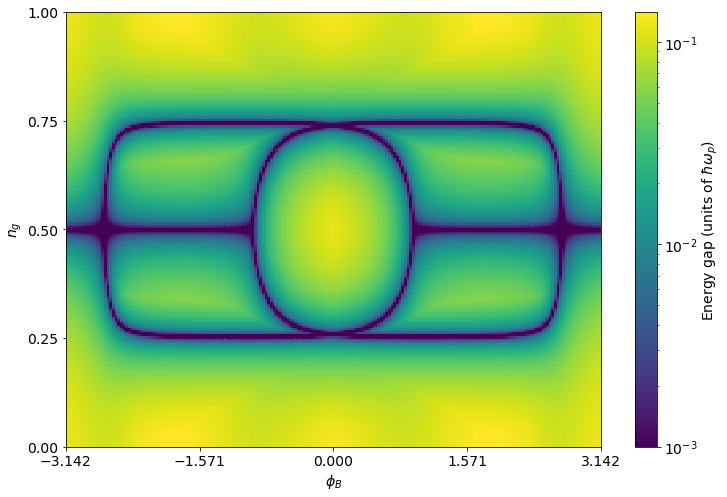

In [8]:
plt.close('all')
fig=plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 14})

X,Y = np.meshgrid(phiBlist_,nglist_,indexing='ij')  ### NEED indexing='ij' SO THAT MESHGRID DOES NOT INVERT X AND Y

plt.pcolormesh(X,Y,deg_gap_/np.sqrt(2), shading='nearest', norm=colors.LogNorm(vmin=1e-3), cmap='viridis') #divide by sqrt(2)=hbar omega_p
plt.colorbar(label='Energy gap (units of $\hbar \omega_p$)')
plt.xlabel('$\phi_B$')
plt.ylabel('$n_g$')
plt.xticks(np.arange(-np.pi,1.5*np.pi,0.5*np.pi))
plt.yticks(np.arange(0,1.25,0.25))

plt.show()